# Polynomial Collocation (Interpolation/Extrapolation) and Approximation

**References:**

- Section 3.1 *Data and Interpolating Functions* in {cite}`Sauer`.
- Section 3.1 *Interpolation and the Lagrange Polynomial* in {cite}`Burden-Faires`.
- Section 4.1 in {cite}`Chenney-Kincaid`.

## Introduction

Numerical methods for dealing with functions require describing them, at least approximately, using a finite list of numbers, and the most basic approach is to approximate by a polynomial.
(Other important choices are rational functions and "trigonometric polynomials": sums of multiples of sines and cosines.)
Such polynomials can then be used to aproximate derivatives and integrals.

The simplest idea for approximating $f(x)$ on domain $[a, b]$ is to start with a finite collection of **node** values $x_i \in [a, b]$, $0 \leq i \leq n$ and then seek a polynomial $p$ which **collocates** with $f$ at those values: $p(x_i) = f(x_i)$ for $0 \leq i \leq n$.
Actually, we can put the function aside for now, and simply seek a polynomial that passes through a list of points $(x_i, y_i)$; later we will achieve collocation with $f$ by choosing $y_i = f(x_i)$.

In fact there are infinitely many such polynomials: given one, add to it any polynomial with zeros at all of the $n+1$ notes.
So to make the problem well-posed, we seek the collocating polynomial of *lowest degree*.

```{prf:theorem} Existence and uniqueness of a collocating polynomial
:label: theorem-collocation

Given $n+1$ distinct values $x_i$, $0 \leq i \leq n$, and corresponding $y$-values $y_i$,
there is a unique polynomial $P$ of degree at most $n$ with $P(x_i) = y_i$ for $0 \leq i \leq n$.

(*Note:* although the degree is typically $n$, it can be less; as an extreme example, if all $y_i$ are equal to $c$, then $P(x)$ is that constant $c$.)
```

Historically there are several methods for finding $P_n$ and proving its uniqueness, in particular, the *divided difference* method introduced by Newton and the *Lagrange polynomial* method.
However for our purposes, and for most modern needs, a different method is easiest, and it also introduces a strategy that will be of repeated use later in this course: the **Method of Undertermined Coefficients** or **MUC**.

In general, this method starts by assuming that the function wanted is a sum of unknown multiples of a collection of known functions.
Here, $P(x) =  c_0 + c_1 x + \cdots + c_{n-1} x^{n-1} + c_n x^n = \sum_{j=0}^n c_j x^j$.
<br>
(*Note:* any of the $c_i$ could be zero, including $c_n$, in which case the degree is less than $n$.)
<br>
The unknown factors ($c_0 \cdots c_n$) are the *undetermined coefficients.*

Next one states the problem as a system of equations for these undetermined coefficients, and solves them.
<br>
Here, we have $n+1$ conditions to be met:

$$P(x_i) = \sum_{j=0}^n c_j x_i^j = y_i, \quad 0 \leq i \leq n$$

This is a system if $n+1$ simultaneous linear equations in $n+1$ unknowns, so the question of existence and uniqueness is exactly the question of whether the corresponding matrix is singular,
and so is equivalent to the case of all $y_i = 0$ having *only* the solution with all
$c_i = 0$.

Back in terms of polynomials, this is the claim that the only polynomial of degree at most $n$ with zeros $x_0 \dots x_n$.
And this is true, because any non-trivial polynomial with those $n+1$ distinct roots is of degree at least $n+1$, so the only "degree n" polynomial fitting this data is $P(x) \equiv 0$.
The theorem is proven.

The proof of this theorem is completely constructive, and it gives the only numerical method we need.

Briefly, the algorithm is this (indexing from 0 !)
- Create the $n+1 \times n+1$ matrix $V$ with elements

$$v_{i,j} = x_i^j,\; 0 \leq i \leq n, \, 0 \leq j \leq n$$

and the $n+1$-element column vector $y$ with elements $y_i$ as above.
- Solve $V c = y$ for the vector of coefficients $c_j$ as above.

I use the name $V$ because this is called the **Vandermonde Matrix.**

Enable graph plotting; PyPlot is an interface to the Python package `matplotlib.pyplot`

If this does not work in a downloaded notebook, see the instructions in the introduction.

In [1]:
using PyPlot

In [2]:
# A helper function, short-hand for rounding
import Base: round
round(x, n) = Base.round(x, sigdigits=n);

```{prf:example} Exact fit
:label: interpolation-example-1

As usual, I concoct a first example with known correct answer, by using a polynomial as $f$:

$$ f(x) = 4 + 7x -2x^2 - 5x^3 + 2x^4 $$

using the nodes $x_0 = 1$, $x_1 = 2$, $x_2= 0$, $x_3 = 3.3$ and $x_4 = 4$  (They do not need to be in order.)
```

In [3]:
f(x) = 4 + 7x -2x^2 - 5x^3 + 2x^4;

```{prf:remark} A Julia shorthand for products
:label: multiplication-by-juxtaposition-in-julia
Note the convenient short-hand of writing products by juxtapositon, without `*`.
This works when the first factor is a literal number, not a variable name.

To avoid ambiguity with the use of dots for *vectorization* introduced below,
avoid ending a floating point number with a period when it it an integer;
for example you can use

    f(x) = 4 + 7x ...
or

    f(x) = 4 + 7.0x ...

but not

    f(x) = 4 + 7.x + ...
```

In [4]:
xnodes = [1., 2., 0., 3.3, 4.]  # They do not need to be in order
println("The x nodes 'x_i' are $(xnodes)")
ynodes = f.(xnodes)
println("The y values at the nodes are $(round.(ynodes, 6))")  # Rounded for nicer display

The x nodes 'x_i' are [1.0, 2.0, 0.0, 3.3, 4.0]
The y values at the nodes are [6.0, 2.0, 4.0, 62.8192, 192.0]


```{prf:remark} Vectorizing a Julia function
:label: julia-vectorization

Appending the "point" to the function name (so it is `f.(...)` instead of `f(...)`) does **vectorization**:
the function `f` is applied "pointwise", to each element of the input array `x_nodes` in turn,
with the results returned in an aray of the same size and shape.


If there are several arguments, all are vectorized.

See {ref}`vectorization-of-functions` in the {doc}`julia-language-notes`.

We will see this again soon.
```

The Vandermonde matrix:

In [5]:
nnodes = length(xnodes)
n = nnodes-1
V = zeros(nnodes, nnodes)
for i in 0:n
    for j in 0:n
        V[i+1,j+1] = xnodes[i+1]^j  # Shift the array indices up by one, since Julia counts from 1, not 0.
    end
end

Solve, using our functions seen in earlier sections and gathered in {doc}`NumericalMethods`

In [6]:
include("NumericalMethods.jl")
using .NumericalMethods: solvelinearsystem, printmatrix

In [7]:
c_A = solvelinearsystem(V, ynodes)
# It helps the visual presentation to round off;
c_A = round.(c_A, 6)
println("The coefficients of P are $c_A")

The coefficients of P are [4.0, 7.0, -2.0, -5.0, 2.0]


These are correct!

To compare the computed values P[i] to what they shoudl be (y_nodes[i])
we use the convenient tool `zip` for looping over two or more "parallel" lists of values:
`zip(x,y)` effectively produces a list of pairs `[(x[1], y[1]), (x[2], y[2]) ...)` up till one or both arrays runs out of elements,
and it also works for three or more lists.

We can also check the resulting values of the polynomial:

In [8]:
P = c_A[1] .+ c_A[2]*xnodes + c_A[3]*xnodes.^2 + c_A[4]*xnodes.^3 + c_A[5]*xnodes.^4;

```{prf:remark} Vectorizing operators and broadcasting values in Julia
:label: vectorization-broadcasting-in-julia

The period prefix in the exponential notation `.^` and the sum notation `.+` is **vectorization** and **broadcasting**:

- **vectorization**: `a.^b` means that if one of `a` and `b` are arrays (or both are arrays, of the same shape and size) then the exponentiation is applied to each element in turn, producing an array of the same size and shape;

- **brodcasting** of the addition: that first addition is "number plus array";
the notation `.+` indicates that this be done by promoting the number to an array matching the other addend.

Vectorization can also be applied to other binary operations such as multiplication and division.

See the notes on
{ref}`vectorization-and-broadcasting`
in {doc}`julia-language-notes`.
```

Now we can check the $y$ values

```{prf:remark} Zipping arrays together in Julia
:label: zip-in-julia

The function `zip` takes two or more arrays (preferably of the same size and shape) and turns them into an array with each element a tuple of values, one from the corresponding position in each input array.

For example, with 1D arrays `x` and `y` of length n, `zip(x, y)` is `[ ( x[1], y[1] ), ( x[2], y[2] )  ... ( x[n], y[n] ) ]`
```

In [9]:
for (x, y, P_i) in zip(xnodes, ynodes, P)
    println("P($x) should be $(round(y, 6)); it is $(round(P_i, 6))")
end

P(1.0) should be 6.0; it is 6.0
P(2.0) should be 2.0; it is 2.0
P(0.0) should be 4.0; it is 4.0
P(3.3) should be 62.8192; it is 62.8192
P(4.0) should be 192.0; it is 192.0


(polyfit-polyval)=
## Functions for computing the coefficients and evaluating the polynomials

We will use this procedure several times, so it time to put it into a functions.
The names `polyfit` and `polyval` come from very similar functions that are standard in Python and Matlab.

We also add a pretty printer for polynomials, and import the pretty printer `printmatrix` for matrices.

In [10]:
function polyfit(x, y)
    # Compute the coeffients c_i of the polynomial of lowest degree that collocates the points (x[i], y[i]).
    # These are returned in an array c of the same length as x and y, even if the degree is less than the normal length(x)-1,
    # in which case the array has some trailing zeroes.
    # The polynomial is thus p(x) = c[1] + c[2]x + ... c[n+1] x^n where n=length(x)-1, the nominal degree.

    nnodes = length(x)
    n = nnodes - 1
    V = zeros(nnodes, nnodes)
    for i in 0:n
        for j in 0:n
             V[i+1,j+1] = x[i+1]^j  # Shift the array indices up by one, since Julia counts from 1, not 0.
        end
    end
    c = solvelinearsystem(V, y)
    return c
end;

In [11]:
function polyval(x; coeffs)  # coeffs has to be a keyword argument in order that only x gets vectorized
    # Evaluate the polynomial with coefficients in c (as given by polyfit, for example).
    n = length(coeffs) - 1
    powers = collect(0:n)  # function collect turns the "AbstractRange" 0:n into an array of numbers.
    y = sum(coeffs .* x.^powers)
    return y
end;

In [12]:
function displaypolynomial(c; sigdigits=6)
    # Note that the function "print" does not end by going to a new line as `println` does;
    # this is useful when you want to create a line of output piece-by-piece, as done here.

    c = round.(c, sigdigits) # Clean up by rounding to sigdigits significant digits; yes, that's vectorization again.
    degree=length(c)-1
    print("P_$(degree)(x) = ")
    print(c[1])
    if degree > 0
        c_1 = c[2]
        if c_1 > 0
            print(" + $(c_1)x")
        elseif coeff < 0
            print(" - $(-c_1) x")
        end
    end
    if degree > 1
        for j in 2:degree
            c_j = c[j+1]
            if c_j > 0
                print(" + $(c_j)x^$j")
            elseif c_j < 0
                print(" - $(-c_j)x^$j")
            end
            # Note: if c_j=0, there is nothing to say.
         end
    end
    println()
end;

```{prf:example} $f(x)$ not a polynomial of degree $\leq n$
:label: interpolation-example-2

Make an exact fit impossible by using the same function but using only four nodes and reducing the degree of the interpolating $P$ to three:
$x_0 = 1$, $x_1 = 2$, $x_2 = 3$ and $x_3 = 4$
```

In [13]:
xnodes = [1., 2., 3., 4.];
println("The x nodes 'x_i' are $xnodes")
ynodes = f.(xnodes)
println("The y values at the nodes are $ynodes")
c_B = polyfit(xnodes, ynodes);
displaypolynomial(c_B)

The x nodes 'x_i' are [1.0, 2.0, 3.0, 4.0]
The y values at the nodes are [6.0, 2.0, 34.0, 192.0]
P_3(x) = -44.0 + 107.0x - 72.0x^2 + 15.0x^3


There are several ways to assess the accuracy of this fit; we start graphically, and later consider the maximum and root-mean-square (RMS) errors.

In [14]:
xplot = range(0.9, 4.1, 100)  # for graphing: go a bit beyond the nodes
fplot = f.(xplot);
Pplot = polyval.(xplot, coeffs=c_B);

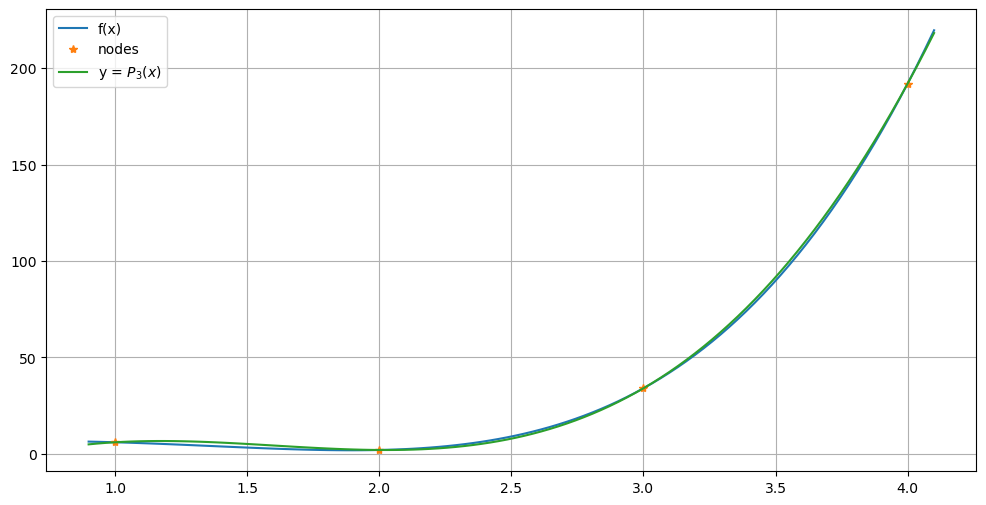

In [15]:
figure(figsize=[12,6])
plot(xplot, fplot, label="f(x)")
plot(xnodes, ynodes, "*", label="nodes")
plot(xplot, Pplot, label=L"y = $P_3(x)$")
legend()
grid(true);

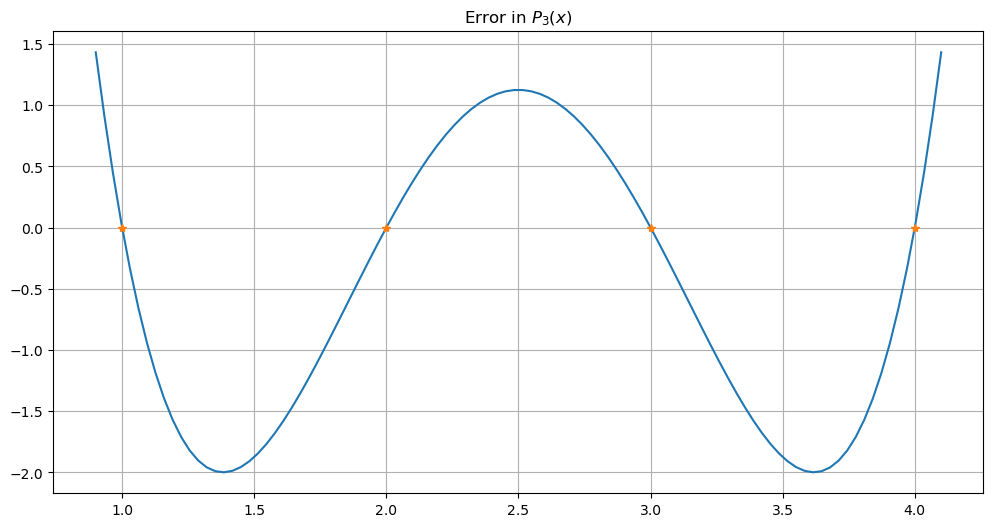

In [16]:
Perror = fplot - Pplot
figure(figsize=[12,6])
title(L"Error in $P_3(x)$")
plot(xplot, Perror)
plot(xnodes, zero(xnodes), "*")
grid(true)

```{prf:example} $f(x)$ not a polynomial at all
:label: interpolation-example-3

$f(x) = e^x$ with five nodes, equally spaced from $-1$ to $1$
```

In [17]:
g(x) = exp(x)
a_g = -1.0
b_g = 1.0;

In [18]:
degree = 4
n_nodes = degree + 1

xnodes = range(a_g, b_g, n_nodes)
gnodes = g.(xnodes)
c_C = polyfit(xnodes, gnodes)
println("node x values $xnodes")
println("node y values $(round.(gnodes, 4))")
displaypolynomial(c_C, sigdigits=4)

node x values -1.0:0.5:1.0
node y values [0.3679, 0.6065, 1.0, 1.649, 2.718]
P_4(x) = 1.0 + 0.9979x + 0.4996x^2 + 0.1773x^3 + 0.04344x^4


For comparison, the degree 4 Taylor polynomial for $e^x$ with center 0 is (to the same 6 significant digits)

$$ 1 + x + 0.5 x^2 + 0.1667 x^3 + 0.04167 x^4$$

In [19]:
xplot = range(a_g - 0.2, b_g + 0.2, 100)  # Go a bit beyond the nodes in each direction
gplot = g.(xplot)
Pplot_g = polyval.(xplot, coeffs=c_C);

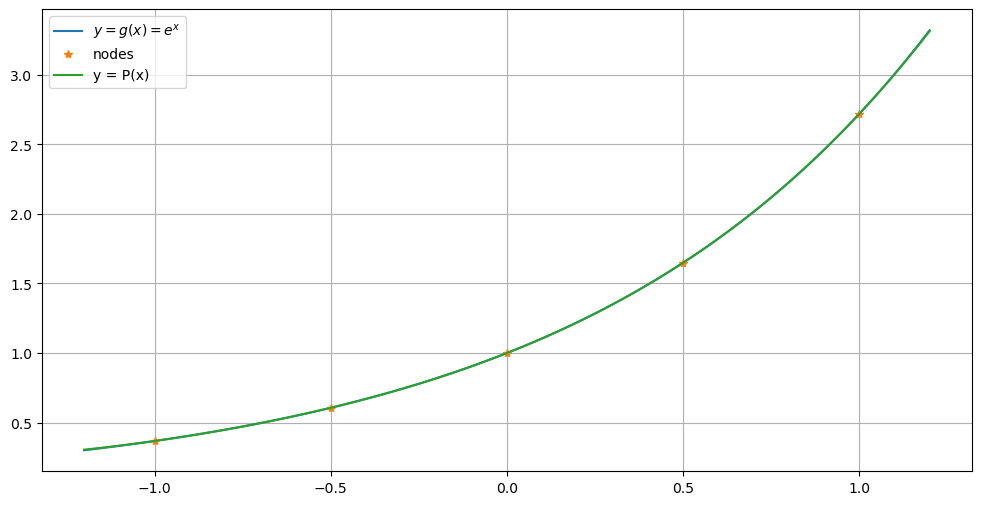

In [20]:
figure(figsize=[12,6])
plot(xplot, gplot, label=L"y = g(x) = e^x")
plot(xnodes, gnodes, "*", label="nodes")
plot(xplot, Pplot_g, label="y = P(x)")
legend()
grid(true)

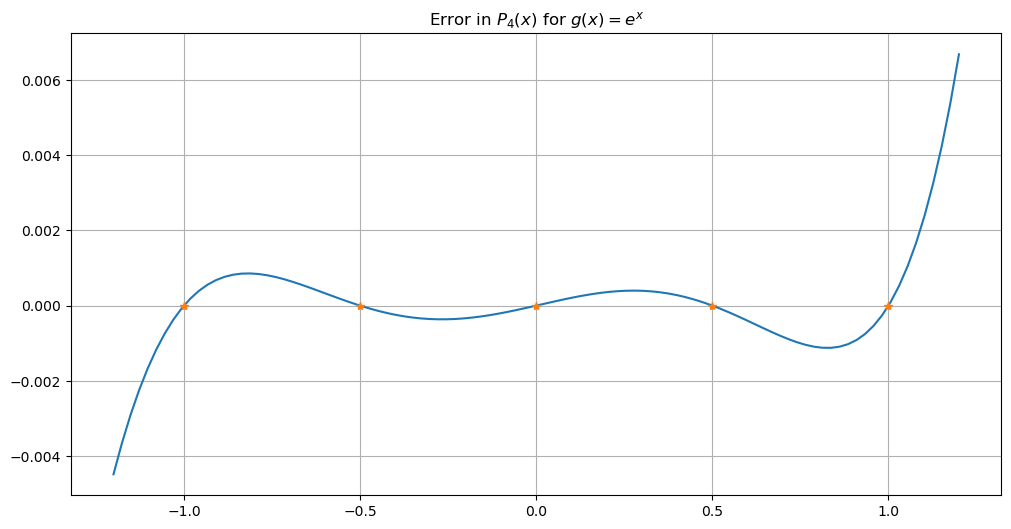

In [21]:
Perror_g = gplot - Pplot_g
figure(figsize=[12,6])
degree = 8
title(L"Error in $P_4(x)$ for $g(x) = e^x$")
plot(xplot, Perror_g)
plot(xnodes, zero(xnodes), "*")
grid(true)